In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [2]:
# Grab and process the raw data.
snt_train = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
snt_train.columns = ['sentance', 'score']

In [3]:
snt_train['sentance'] = snt_train['sentance'].str.replace('\'','')
snt_train['sentance'] = snt_train['sentance'].str.replace('.',' ')
snt_train['sentance'] = snt_train['sentance'].str.replace(',',' ')

In [4]:
# collect the words from positive and negative reviews
words_pos = re.findall('\w+', ' '.join(snt_train[snt_train['score'] == 1].sentance.tolist()).lower())
words_neg = re.findall('\w+', ' '.join(snt_train[snt_train['score'] == 0].sentance.tolist()).lower())

# remove words that are in both lists
words_pos_unique = [x for x in words_pos if x not in words_neg]
words_neg_unique = [x for x in words_neg if x not in words_pos]

In [5]:
# some of the top 20 positive words are directly related to the product (i.e. cases
# keyboard, leather).  This model will be used for other products so these 
# words should be removed so that we have a generic top 10
Counter(words_pos_unique).most_common(20)

[('nice', 22),
 ('love', 20),
 ('perfectly', 6),
 ('value', 5),
 ('sturdy', 5),
 ('definitely', 5),
 ('free', 5),
 ('pleased', 5),
 ('charm', 5),
 ('awesome', 5),
 ('overall', 5),
 ('range', 5),
 ('cases', 5),
 ('seems', 4),
 ('keyboard', 4),
 ('order', 4),
 ('leather', 4),
 ('fast', 4),
 ('comfortably', 4),
 ('glad', 4)]

In [6]:
# after reviewing the positive words, remove the highest occurring words that refer to the product specifically 
words_pos_prod_specific = ['sturdy','free','charm','range','cases','keyboard','order','leather','fast','comfortably']
words_pos_unique_generic=[x for x in words_pos_unique if x not in words_pos_prod_specific]

In [7]:
# some of the top 20 negative words are directly related to the product (i.e. cases
# keyboard, leather).  This model will be used for other products so these 
# words should be removed so that we have a generic top 10
Counter(words_neg_unique).most_common(20)

[('poor', 15),
 ('waste', 14),
 ('bad', 14),
 ('worst', 14),
 ('disappointed', 10),
 ('terrible', 10),
 ('broke', 8),
 ('horrible', 8),
 ('junk', 8),
 ('unit', 8),
 ('didnt', 7),
 ('useless', 7),
 ('stay', 6),
 ('crap', 6),
 ('difficult', 6),
 ('week', 5),
 ('disappointment', 5),
 ('return', 5),
 ('old', 5),
 ('anything', 5)]

In [8]:
# after reviewing the negative words, remove the highest occurring words that refer to the product specifically 
words_neg_prod_specific = ['broke','junk','unit','stay']
words_neg_unique_generic=[x for x in words_neg_unique if x not in words_neg_prod_specific]

In [9]:
# collect the top 10 words from the positive and negative reviews
words_pos_unique_generic_top10 = Counter(words_pos_unique_generic).most_common(10)
words_neg_unique_generic_top10 = Counter(words_neg_unique_generic).most_common(10)

In [10]:
def AddWordFeat(feats, prefix, word, snt):
    newFeatName=str(prefix)+'_'+str(word)
    feats[newFeatName] = snt.sentance.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    return feats

In [11]:
def CreateSetOfFeatures(feats, prefix, wordList, snt):
    for word in wordList:
        feats = AddWordFeat(feats,prefix, word, snt)
    return feats

In [12]:
feats_p = pd.DataFrame()
wordList = np.array(words_pos_unique_generic_top10)[:,0]
feats_p = CreateSetOfFeatures(feats_p, 'p', wordList, snt_train)

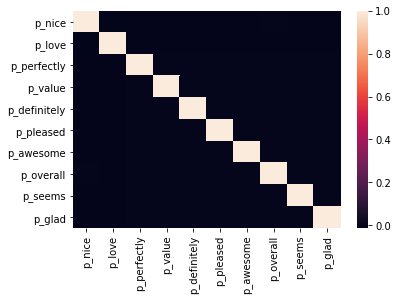

In [13]:
sns.heatmap(feats_p.corr())

In [14]:
feats_n = pd.DataFrame()
wordList = np.array(words_neg_unique_generic_top10)[:,0]
feats_n = CreateSetOfFeatures(feats_n, 'n', wordList, snt_train)

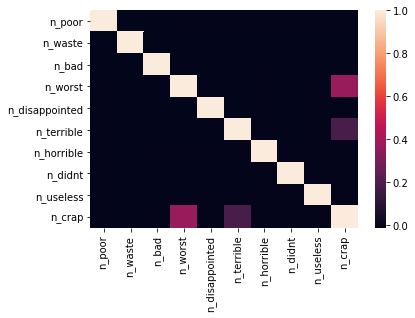

In [15]:
sns.heatmap(feats_n.corr())

In [16]:
# Bernoulli classifier
def BnbClassifier (data, target):
    # Our data is binary / boolean, so we're importing the Bernoulli classifier.
    from sklearn.naive_bayes import BernoulliNB

    # Instantiate our model and store it in a new variable.
    bnb = BernoulliNB()

    # Fit our model to the data.
    bnb.fit(data, target)
    
    y_pred = bnb.predict(data)

    return y_pred,bnb

In [17]:
# Bernoulli classifier
def MnbClassifier (data, target):
    # importing the Multinomial classifier.
    from sklearn.naive_bayes import MultinomialNB
    
    mnb = MultinomialNB()
    mnb.fit(data, target)
    y_pred = mnb.predict(data)

    return y_pred,bnb

In [18]:
# Display our results.
def DisplayResults(data, y_pred):
    print("\nRESULTS:\n")
    print("Number of mislabeled points out of a total {} points : {}".format(
        data.shape[0],
        (target != y_pred).sum()
    ))

In [19]:
# confusion matrix
def ConfusionMatrix(target, y_pred):
    df_confusion = pd.crosstab(target, y_pred, rownames=['Actual'], colnames=['Predicted'])
    
    print ('\nCONFUSION MATRIX:\n ')
    print (df_confusion)

    print ('\nwhen a message was pos and we predicted pos: ', df_confusion[1][1])
    print ('when a message was pos and we predicted neg: ', df_confusion[0][1])
    print ('when a message was neg and we predicted neg: ',df_confusion[0][0])
    print ('when a message was neg and we predicted pos: ',df_confusion[1][0])

    total_pos = df_confusion[0][1] + df_confusion[1][1]
    correct_pos = df_confusion[1][1]
    total_neg = df_confusion[0][0] + df_confusion[1][0]
    correct_neg = df_confusion[0][0]
    sensitivity = (correct_pos/total_pos)*100
    specificity = (correct_neg/total_neg)*100

    print('\ntotal positives = ', total_pos)
    print('correct positives = ', correct_pos)
    print('sensitivity = ',sensitivity,'%')
    print('\ntotal negatives = ', total_neg)
    print('correct negatives = ', correct_neg)
    print('specificity = ',specificity,'%')

In [20]:
# cross validation
def CrossValidation(bnb, data, target):
    crossValScore = []
    print ('\nCROSS VALIDATION:')
    from sklearn.model_selection import cross_val_score
    crossValScore = cross_val_score(bnb, data, target, cv=10)
    print (crossValScore)
    #return cossValScore

In [21]:
def BnbComplete(data, target):
    y_pred,bnb = BnbClassifier (data, target)
    DisplayResults(data, y_pred)
    ConfusionMatrix(target, y_pred)
    CrossValidation(bnb, data, target)
    return y_pred

In [22]:
def MnbComplete(data, target):
    crossValScore = []
    y_pred,mnb = MnbClassifier (data, target)
    DisplayResults(data, y_pred)
    ConfusionMatrix(target, y_pred)
    crossValScore = CrossValidation(mnb, data, target)
    return y_pred

In [23]:
def CompareFeatureSets(featSetList, Y):
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.model_selection import cross_val_score
    results = []
    names = []
    seed = 7
    for name,feats in featSetList:
        y_pred,bnb=BnbClassifier (feats, Y)
        bb = BernoulliNB()
        cvresult = cross_val_score(BernoulliNB(), feats, Y, cv=10)
        results.append(cvresult)
        names.append(name)
        msg = "%s: mean: %f standard deviation:(%f)" % (name, cvresult.mean(), cvresult.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Feature Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [24]:
feats_p.head()

p_nice  p_love  p_perfectly  p_value  p_definitely  p_pleased  p_awesome  \
0   False   False        False    False         False      False      False   
1   False   False        False     True         False      False      False   
2   False   False        False    False         False      False      False   
3   False   False        False    False         False      False      False   
4   False   False        False    False         False      False      False   

   p_overall  p_seems  p_glad  
0      False    False   False  
1      False    False   False  
2      False    False   False  
3      False    False   False  
4      False    False   False

In [25]:
target = snt_train['score']
data = feats_p
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 439

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          439  61

when a message was pos and we predicted pos:  61
when a message was pos and we predicted neg:  439
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  61
sensitivity =  12.2 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.56  0.61  0.56  0.54  0.58  0.58  0.56  0.54  0.54  0.54]


In [26]:
feats_n.head()

n_poor  n_waste  n_bad  n_worst  n_disappointed  n_terrible  n_horrible  \
0   False    False  False    False           False       False       False   
1   False    False  False    False           False       False       False   
2   False    False  False    False           False       False       False   
3   False    False  False    False           False       False       False   
4   False    False  False    False           False       False       False   

   n_didnt  n_useless  n_crap  
0    False      False   False  
1    False      False   False  
2    False      False   False  
3    False      False   False  
4    False      False   False

In [27]:
target = snt_train['score']
data = feats_n
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 435

CONFUSION MATRIX:
 
Predicted   0    1
Actual            
0          65  435
1           0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  65
when a message was neg and we predicted pos:  435

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  65
specificity =  13.0 %

CROSS VALIDATION:
[ 0.57  0.57  0.6   0.58  0.54  0.54  0.58  0.52  0.58  0.57]


In [28]:
featSetList = []
featSetList.append(('feats_p', feats_p))
featSetList.append(('feats_n', feats_n))

feats_p: mean: 0.561000 standard deviation:(0.022113)
feats_n: mean: 0.565000 standard deviation:(0.022913)


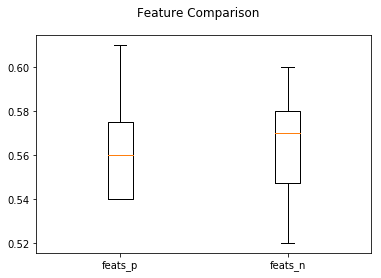

In [29]:
CompareFeatureSets(featSetList, snt_train['score'])

In [30]:
feats_pn = pd.concat([feats_p, feats_n], axis=1)

In [31]:
feats_pn.head()

p_nice  p_love  p_perfectly  p_value  p_definitely  p_pleased  p_awesome  \
0   False   False        False    False         False      False      False   
1   False   False        False     True         False      False      False   
2   False   False        False    False         False      False      False   
3   False   False        False    False         False      False      False   
4   False   False        False    False         False      False      False   

   p_overall  p_seems  p_glad  n_poor  n_waste  n_bad  n_worst  \
0      False    False   False   False    False  False    False   
1      False    False   False   False    False  False    False   
2      False    False   False   False    False  False    False   
3      False    False   False   False    False  False    False   
4      False    False   False   False    False  False    False   

   n_disappointed  n_terrible  n_horrible  n_didnt  n_useless  n_crap  
0           False       False       False    False      False   False  
1           False       False       False    False      False   False  
2           False       False       False    False      False   False  
3           False       False       False    False      False   False  
4           False       False       False    False      False   False

In [32]:
target = snt_train['score']
data = feats_pn
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 435

CONFUSION MATRIX:
 
Predicted   0    1
Actual            
0          65  435
1           0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  65
when a message was neg and we predicted pos:  435

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  65
specificity =  13.0 %

CROSS VALIDATION:
[ 0.57  0.57  0.6   0.58  0.54  0.54  0.58  0.52  0.58  0.57]


feats_p: mean: 0.561000 standard deviation:(0.022113)
feats_n: mean: 0.565000 standard deviation:(0.022913)
feats_pn: mean: 0.565000 standard deviation:(0.022913)


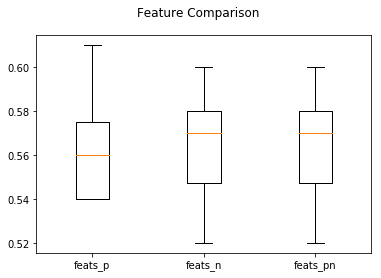

In [33]:
featSetList = []
featSetList.append(('feats_p', feats_p))
featSetList.append(('feats_n', feats_n))
featSetList.append(('feats_pn', feats_pn))

CompareFeatureSets(featSetList, snt_train['score'])

In [34]:
# collect sentences, actual score, and predicted
snt_train_pred = snt_train
snt_train_pred['pred'] = y_pred

In [35]:
# collect negative reviews that were predicted positive
snt_train_pred_s0_p1 = snt_train_pred[(snt_train_pred['score']==0) & (snt_train_pred['pred']==1)]

In [36]:
# get all of the words from these reviews
snt_raw_pred_s0_p1_words = re.findall('\w+', ' '.join(snt_train_pred_s0_p1.sentance.tolist()).lower())

In [37]:
# collect words that have not already been used in neg word feature
snt_raw_pred_s0_p1_words_new = [x for x in snt_raw_pred_s0_p1_words if x not in words_neg_unique_generic_top10]

In [38]:
# list the most common
Counter(snt_raw_pred_s0_p1_words_new).most_common(10)

[('the', 248),
 ('i', 149),
 ('it', 140),
 ('and', 111),
 ('to', 100),
 ('not', 97),
 ('a', 95),
 ('this', 92),
 ('is', 83),
 ('phone', 71)]

In [39]:
# collect positive reviews that were predicted positive
snt_train_pred_s1_p1 = snt_train_pred[(snt_train_pred['score']==1) & (snt_train_pred['pred']==1)]
# get all of the words from these reviews
snt_raw_pred_s1_p1_words = re.findall('\w+', ' '.join(snt_train_pred_s1_p1.sentance.tolist()).lower())
# collect words that have not already been used in neg word feature
snt_raw_pred_s1_p1_words_new = [x for x in snt_raw_pred_s1_p1_words if x not in words_neg_unique_generic_top10]

Counter(snt_raw_pred_s1_p1_words_new).most_common(10)

[('the', 239),
 ('and', 189),
 ('i', 156),
 ('is', 141),
 ('it', 129),
 ('a', 106),
 ('this', 105),
 ('great', 94),
 ('to', 87),
 ('phone', 87)]

In [40]:
# "not" seems to be in many of the top negative reviews but not in the top positive reviews
# so adding as a new feature
feats_pn_plus_n = pd.DataFrame()
feats_pn_plus_n = pd.concat([feats_pn, feats_pn_plus_n], axis=1)
#feats_pn_plus_n = feats_pn
feats_pn_plus_n['n_not'] = snt_train.sentance.str.contains(' not ',case=False)

In [41]:
feats_pn_plus_n.head()

p_nice  p_love  p_perfectly  p_value  p_definitely  p_pleased  p_awesome  \
0   False   False        False    False         False      False      False   
1   False   False        False     True         False      False      False   
2   False   False        False    False         False      False      False   
3   False   False        False    False         False      False      False   
4   False   False        False    False         False      False      False   

   p_overall  p_seems  p_glad  ...    n_waste  n_bad  n_worst  n_disappointed  \
0      False    False   False  ...      False  False    False           False   
1      False    False   False  ...      False  False    False           False   
2      False    False   False  ...      False  False    False           False   
3      False    False   False  ...      False  False    False           False   
4      False    False   False  ...      False  False    False           False   

   n_terrible  n_horrible  n_didnt  n_useless  n_crap  n_not  
0       False       False    False      False   False  False  
1       False       False    False      False   False  False  
2       False       False    False      False   False  False  
3       False       False    False      False   False  False  
4       False       False    False      False   False  False  

[5 rows x 21 columns]

In [42]:
target = snt_train['score']
data = feats_pn_plus_n
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 368

CONFUSION MATRIX:
 
Predicted    0    1
Actual             
0          145  355
1           13  487

when a message was pos and we predicted pos:  487
when a message was pos and we predicted neg:  13
when a message was neg and we predicted neg:  145
when a message was neg and we predicted pos:  355

total positives =  500
correct positives =  487
sensitivity =  97.4 %

total negatives =  500
correct negatives =  145
specificity =  29.0 %

CROSS VALIDATION:
[ 0.62  0.68  0.67  0.63  0.62  0.56  0.68  0.58  0.66  0.62]


feats_p: mean: 0.561000 standard deviation:(0.022113)
feats_n: mean: 0.565000 standard deviation:(0.022913)
feats_pn: mean: 0.565000 standard deviation:(0.022913)
feats_pn_plus_n: mean: 0.632000 standard deviation:(0.038936)


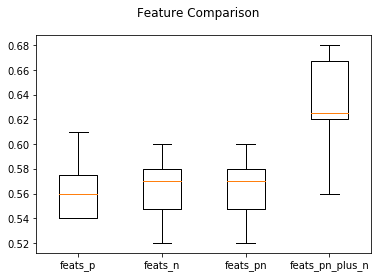

In [43]:
featSetList = []
featSetList.append(('feats_p', feats_p))
featSetList.append(('feats_n', feats_n))
featSetList.append(('feats_pn', feats_pn))
featSetList.append(('feats_pn_plus_n', feats_pn_plus_n))

CompareFeatureSets(featSetList, snt_train['score'])

In [44]:
from sklearn.feature_selection import RFE

target = snt_train['score']
data = feats_pn_plus_n
y_pred,bnb = BnbClassifier (data, target)

featSelector = RFE(bnb)
featSelector = featSelector.fit(data, target)

In [45]:
print(featSelector.ranking_)

[10 12  7  9  6  8  5  2  4  3  1  1  1  1  1  1  1  1  1  1 11]


In [46]:
rankings = pd.DataFrame({'Features': data.columns, 'Ranking' : featSelector.ranking_})
rankings.sort_values('Ranking')

Features  Ranking
10          n_poor        1
15      n_terrible        1
14  n_disappointed        1
13         n_worst        1
12           n_bad        1
11         n_waste        1
19          n_crap        1
16      n_horrible        1
17         n_didnt        1
18       n_useless        1
7        p_overall        2
9           p_glad        3
8          p_seems        4
6        p_awesome        5
4     p_definitely        6
2      p_perfectly        7
5        p_pleased        8
3          p_value        9
0           p_nice       10
20           n_not       11
1           p_love       12

In [47]:
feats_selected = pd.DataFrame()
feats_selected = pd.concat([feats_selected, feats_pn_plus_n], axis=1)
feats_selected = feats_selected.drop(['p_love', 'n_not', 'p_nice', 'p_value', 'p_pleased', 'p_perfectly', 'p_definitely', 'p_awesome', 'p_seems', 'p_glad', 'p_overall'], axis=1)


In [48]:
feats_selected.head()

n_poor  n_waste  n_bad  n_worst  n_disappointed  n_terrible  n_horrible  \
0   False    False  False    False           False       False       False   
1   False    False  False    False           False       False       False   
2   False    False  False    False           False       False       False   
3   False    False  False    False           False       False       False   
4   False    False  False    False           False       False       False   

   n_didnt  n_useless  n_crap  
0    False      False   False  
1    False      False   False  
2    False      False   False  
3    False      False   False  
4    False      False   False

In [49]:
target = snt_train['score']
data = feats_selected
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 435

CONFUSION MATRIX:
 
Predicted   0    1
Actual            
0          65  435
1           0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  65
when a message was neg and we predicted pos:  435

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  65
specificity =  13.0 %

CROSS VALIDATION:
[ 0.57  0.57  0.6   0.58  0.54  0.54  0.58  0.52  0.58  0.57]


feats_p: mean: 0.561000 standard deviation:(0.022113)
feats_n: mean: 0.565000 standard deviation:(0.022913)
feats_pn: mean: 0.565000 standard deviation:(0.022913)
feats_pn_plus_n: mean: 0.632000 standard deviation:(0.038936)
feats_selected: mean: 0.565000 standard deviation:(0.022913)


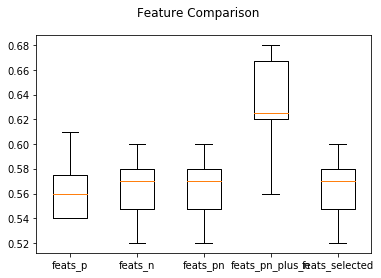

In [50]:
featSetList = []
featSetList.append(('feats_p', feats_p))
featSetList.append(('feats_n', feats_n))
featSetList.append(('feats_pn', feats_pn))
featSetList.append(('feats_pn_plus_n', feats_pn_plus_n))
featSetList.append(('feats_selected', feats_selected))


CompareFeatureSets(featSetList, snt_train['score'])

# Test Set

In [51]:
feat_words = [column[2:] for column in feats_selected.columns if column.startswith('n_')]
#feats_pn_count['neglabels'] = feats_pn_count[neglabels].sum(axis=1)

In [52]:
# Grab and process the raw data.
snt_test = pd.read_csv("yelp_labelled.txt", delimiter='\t', header=None)
snt_test.columns = ['sentance', 'score']
snt_test['sentance'] = snt_train['sentance'].str.replace('\'','')
snt_test['sentance'] = snt_train['sentance'].str.replace('.',' ')
snt_test['sentance'] = snt_train['sentance'].str.replace(',',' ')

In [53]:
# collect words from training feature to create features against the test file
feat_words = [column[2:] for column in feats_selected.columns if column.startswith('n_')]

In [54]:
feats_test = pd.DataFrame()

for key in feat_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_test[key] = snt_test.sentance.str.contains(
        ' ' + key + ' ',
        case=False
    )

In [55]:
feats_test.head()

poor  waste    bad  worst  disappointed  terrible  horrible  didnt  \
0  False  False  False  False         False     False     False  False   
1  False  False  False  False         False     False     False  False   
2  False  False  False  False         False     False     False  False   
3  False  False  False  False         False     False     False  False   
4  False  False  False  False         False     False     False  False   

   useless   crap  
0    False  False  
1    False  False  
2    False  False  
3    False  False  
4    False  False

In [56]:
feats_selected.head()

n_poor  n_waste  n_bad  n_worst  n_disappointed  n_terrible  n_horrible  \
0   False    False  False    False           False       False       False   
1   False    False  False    False           False       False       False   
2   False    False  False    False           False       False       False   
3   False    False  False    False           False       False       False   
4   False    False  False    False           False       False       False   

   n_didnt  n_useless  n_crap  
0    False      False   False  
1    False      False   False  
2    False      False   False  
3    False      False   False  
4    False      False   False

In [57]:
# Train the classifer


In [58]:
# Run the classifier on the Test features

In [59]:
feats_pn_count.head()

NameError: name 'feats_pn_count' is not defined

In [ ]:
target = snt_train['score']
data = feats_pn_count
y_pred = MnbComplete(data,target)

In [ ]:
[column for column in feats_pn_uncorr]

### Model is over predicting negative reviews

Even out the number of columns for pos and neg.

In [ ]:
#>>> df.drop(['B', 'C'], axis=1)

feats_pn_even = feats_pn_uncorr.drop(['n_crap', 'n_useless', 'n_didn','n_horrible'], axis=1)
feats_pn_even.head()

In [ ]:
target = snt_train['score']
data = feats_pn_even
y_pred = MnbComplete(data,target)

In [ ]:
feats_pn_skew_n = feats_pn_even.drop(['n_not'], axis=1)
feats_pn_skew_n.head()

In [ ]:
target = snt_train['score']
data = feats_pn_skew_n
y_pred = MnbComplete(data,target)

In [ ]:
feats_pn_hvy_skew_n = feats_pn_skew_n.drop(['n_terrible','n_disappointed'], axis=1)
feats_pn_hvy_skew_n.head()

In [ ]:
target = snt_train['score']
data = feats_pn_hvy_skew_n
y_pred = MnbComplete(data,target)

### Test Set

In [97]:
# Grab and process the raw data.
snt_test = pd.read_csv("yelp_labelled.txt", delimiter='\t', header=None)
snt_test.columns = ['sentance', 'score']

In [98]:
feats_p = pd.DataFrame()

for key in words_pos_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_p['p_'+str(key[0])] = snt_test.sentance.str.contains(
        ' ' + key[0] + ' ',
        case=False
    )

In [99]:
feats_n = pd.DataFrame()

for key in words_neg_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_n['n_'+str(key[0])] = snt_test.sentance.str.contains(
        key[0],
        case=False
    ) 

In [100]:
# importing the Multinomial classifier.
from sklearn.naive_bayes import BernoulliNB

In [101]:
feats_selected.head()

n_poor  n_waste  n_bad  n_worst  n_disappointed  n_terrible  n_horrible  \
0   False    False  False    False           False       False       False   
1   False    False  False    False           False       False       False   
2   False    False  False    False           False       False       False   
3   False    False  False    False           False       False       False   
4   False    False  False    False           False       False       False   

   n_didnt  n_useless  n_crap  
0    False      False   False  
1    False      False   False  
2    False      False   False  
3    False      False   False  
4    False      False   False

In [102]:
# Train classifer on training features with training file data
# Bernoulli classifier
Y = snt_train['score']
X = feats_selected
    
bnb = BernoulliNB()
bnb.fit(X, Y)

y_pred = bnb.predict(X)

In [103]:
ConfusionMatrix(Y, y_pred)


CONFUSION MATRIX:
 
Predicted   0    1
Actual            
0          65  435
1           0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  65
when a message was neg and we predicted pos:  435

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  65
specificity =  13.0 %


In [104]:
results = []
names = []
crossValScoreTrain = CrossValidation(bnb, X, Y)
results.append(crossValScoreTrain)
names.append('Train')


CROSS VALIDATION:
[ 0.57  0.57  0.6   0.58  0.54  0.54  0.58  0.52  0.58  0.57]


In [105]:
results[0]

In [106]:
# Run on test data

In [107]:
Y = snt_test['score']
X = feats_test
    
y_pred = bnb.predict(X)


In [108]:
ConfusionMatrix(Y, y_pred)


CONFUSION MATRIX:
 
Predicted   0    1
Actual            
0          37  463
1          28  472

when a message was pos and we predicted pos:  472
when a message was pos and we predicted neg:  28
when a message was neg and we predicted neg:  37
when a message was neg and we predicted pos:  463

total positives =  500
correct positives =  472
sensitivity =  94.4 %

total negatives =  500
correct negatives =  37
specificity =  7.4 %


In [109]:
crossValScoreTest = CrossValidation(bnb, X, Y)
results.append(crossValScoreTest)
names.append('Test')


CROSS VALIDATION:
[ 0.5   0.49  0.47  0.51  0.48  0.51  0.49  0.52  0.51  0.51]


In [110]:
names

['Train', 'Test']

In [111]:
results[1]

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

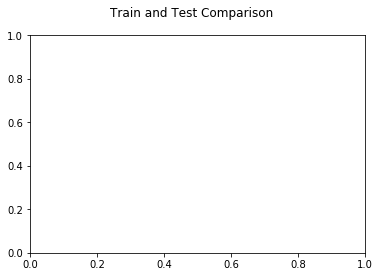

In [112]:
fig = plt.figure()
fig.suptitle('Train and Test Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:

    from sklearn.model_selection import cross_val_score
    results = []
    names = []
    seed = 7
    for name,feats in featSetList:
        y_pred,bnb=BnbClassifier (feats, Y)
        bb = BernoulliNB()
        cvresult = cross_val_score(BernoulliNB(), feats, Y, cv=10)
        results.append(cvresult)
        names.append(name)
        msg = "%s: mean: %f standard deviation:(%f)" % (name, cvresult.mean(), cvresult.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Feature Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [ ]:
feats_n = pd.DataFrame()

for key in words_neg_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_n['n_'+str(key[0])] = snt_train.sentance.str.contains(
        key[0],
        case=False
    ) 

In [ ]:
snt_train_pred_feat = snt_train_pred.join(feats_pn_uncorr)
snt_train_pred_s0_p1 = snt_train_pred_feat[(snt_train_pred_feat['score']==0) & (snt_train_pred_feat['pred']==1)]

In [ ]:
feats_pn_count=pd.DataFrame()
poslabels=[column for column in feats_pn_uncorr.columns if column.startswith('p_')]
feats_pn_count['poslabels'] = feats_pn_uncorr[poslabels].sum(axis=1)

In [ ]:
neglabels=[column for column in feats_pn_uncorr.columns if column.startswith('n_')]
feats_pn_count['neglabels'] = feats_pn_uncorr[neglabels].sum(axis=1)

In [ ]:
feats_pn_count.head()

In [ ]:
target = snt_raw['score']
data = feats_pn_count
MnbComplete(data,target)

In [ ]:
target = (snt_raw['score'] == 0)
data = feats_n_uncorr

In [ ]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

In [ ]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [ ]:
DisplayResults(data, y_pred)

In [ ]:
# Grab and process the raw data.
#snt_raw = pd.read_csv("yelp_labelled.txt", delimiter='\t', header=None)
#snt_raw.columns = ['sentance', 'score']

In [ ]:
target = (snt_raw['score'] == 1)
data = feats_p_uncorr

In [ ]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

In [ ]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [ ]:
DisplayResults(data, y_pred)

In [ ]:
ConfusionMatrix(target, y_pred)

In [ ]:
y_pred = BnbClassifier(data,target)
DisplayResults(data, y_pred)
ConfusionMatrix(target, y_pred)

In [ ]:
BnbComplete(data,target)

### Explanation

The presence of one of the negative feature words in the statement (indicated by "TRUE" in "feats_n_uncorr") independently (the words are not correlated) contribute to the probability that the statement is negative.

In [ ]:
feats_n_uncorr.head()

In [ ]:
feats_p_uncorr.head()

In [ ]:
ConfusionMatrix(target, y_pred)

# Positive and Negative Features Combined

In [ ]:
feats_pn_uncorr = pd.concat([feats_p_uncorr, feats_n_uncorr], axis=1)

In [ ]:
feats_pn_uncorr.head()

In [ ]:
target = snt_raw['score']
data = feats_n_uncorr

In [ ]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

In [ ]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [ ]:
DisplayResults(data, y_pred)

In [ ]:
ConfusionMatrix(target,y_pred)

In [ ]:
feats_pn_uncorr.head()

In [ ]:
poslabels=[column for column in feats_pn_count.columns if column.startswith('p_')]
feats_pn_count['poslabels'] = feats_pn_count[poslabels].sum(axis=1)

In [ ]:
feats_pn_count.head()

In [ ]:
neglabels=[column for column in feats_pn_count.columns if column.startswith('n_')]
feats_pn_count['neglabels'] = feats_pn_count[neglabels].sum(axis=1)

In [ ]:
feats_pn_count.head()

In [ ]:
feats_pn_count[feats_pn_count['poslabels']==1]

In [ ]:
target = snt_raw['score']
data = feats_pn_count

In [ ]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

In [ ]:
DisplayResults(data, y_pred)

In [ ]:
ConfusionMatrix(target,y_pred)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

In [ ]:
CrossValidation(bnb, data, target)

In [ ]:
snt_raw_pred = snt_raw

In [ ]:
snt_raw_pred['pred'] = y_pred
snt_raw_pred_feat = snt_raw_pred.join(feats_pn_count)
snt_raw_pred_s0_p1 = snt_raw_pred_feat[(snt_raw_pred_feat['score']==0) & (snt_raw_pred_feat['pred']==1)]

In [ ]:
snt_raw_pred_s0_p1

In [ ]:
snt_raw_pred_s0_p1_words = re.findall('\w+', ' '.join(snt_raw_pred_s0_p1.sentance.tolist()).lower())
Counter(snt_raw_pred_s0_p1_words).most_common(70)

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

In [ ]:
from nltk.corpus import stopwords
s=set(stopwords.words('english'))

txt="a long string of text about him and her"
#print filter(lambda w: not w in s,snt_raw_pred_s0_p1_words.split())

In [ ]:
Counter(snt_raw_pred_s0_p1_words).most_common(70)

In [ ]:
# collect the words from positive and negative reviews
words_pos = re.findall('\w+', ' '.join(snt_raw[snt_raw['score'] == 1].sentance.tolist()).lower())
words_neg = re.findall('\w+', ' '.join(snt_raw[snt_raw['score'] == 0].sentance.tolist()).lower())

# remove words that are in both lists
words_pos_unique = [x for x in words_pos if x not in words_neg]
words_neg_unique = [x for x in words_neg if x not in words_pos]

In [ ]:
# add some more common positive words, great, good, very

In [ ]:
# could take target vs y_pred to see where the misabled ones are (Neg pred as pos, )

In [ ]:
# if no negative words, mark as positive review

In [ ]:
# check for features that did not get any true and drop